In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
def get_significant(file_path):
    significants = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            x, y = int(int(data[1])/1000), int(int(data[3])/1000)
            p_value, q_value = float(data[5]), float(data[6])
            concat = int(data[4])
            significants.append((x, y, p_value, q_value, concat))
    return significants

def cal_significant(significants, proportion):
    test = np.array(significants)
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _p_values = test[:, 2]
    _test = _filter(_p_values, int(_p_values.shape[0]*proportion), test)
    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def cal_significant_test(significants, proportion):
    test = np.array(significants)

    test = test[np.argsort(test[:, 2])]
    _test = np.zeros((int(test.shape[0]*proportion), 5))
    significant_set = set()
    index = 0
    for i in range(test.shape[0]):
        x, y = int(test[i, 0]), int(test[i, 1])
        flag = False
        for _x in range(x-4, x+5):
            for _y in range(y-4, y+5):
                if (_x, _y) in significant_set:
                    flag = True
                    break
            if flag:
                break
        if flag:
            continue
        significant_set.add((x, y))
        _test[index] = test[i]
        index += 1
        if index > _test.shape[0] - 1:
            break
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def cal_hr_significant(file_path):
    significants = dict()
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            if data[0] != data[3] or float(data[6]) > 0.1:
                continue
            left1, right1 = int(int(data[1])/1000), int(int(data[2])/1000)
            left2, right2 = int(int(data[4])/1000), int(int(data[5])/1000)
            if abs(left2-left1) > 100 or abs(left2-left1) < 2:
                continue
            if int(data[0]) not in significants.keys():
                significants[int(data[0])] = []
            significants[int(data[0])].append((left1, left2))
    return significants

def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(subsets = [hr_sig_set, enhanced_sig_set], set_labels = ('1kb', 'enhanced'), set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


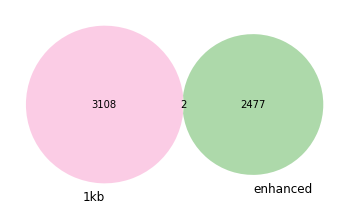

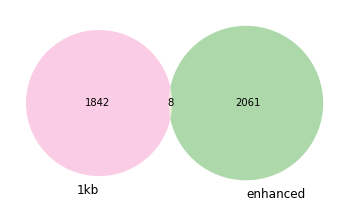

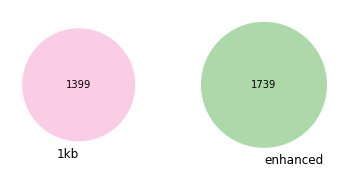

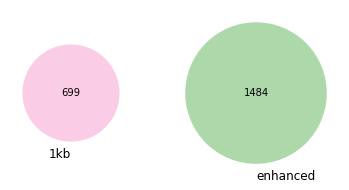

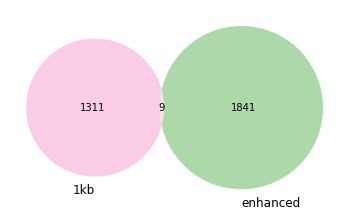

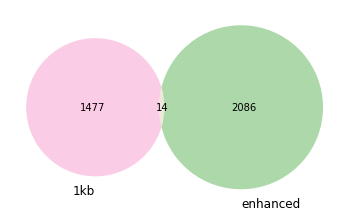

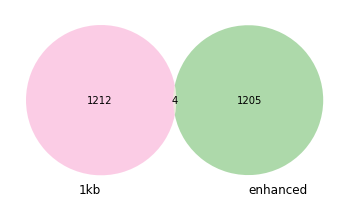

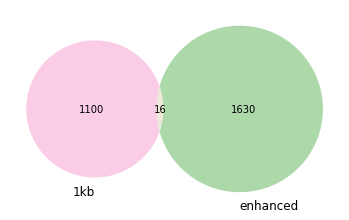

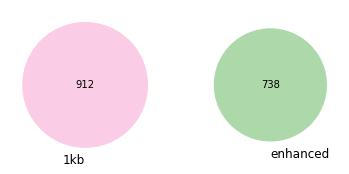

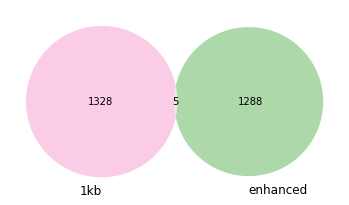

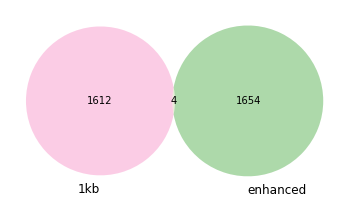

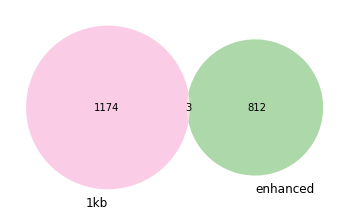

In [3]:
analyse_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/GM12878_ATAC_H3K27ac_H3K4me3'
enhanced_path = os.path.join(analyse_path, 'experiment', 'loop', 'enhanced')
hr_path = os.path.join(analyse_path, 'experiment', 'loop', 'hr')
auxiliary_files_path = '/data1/lmh_data/MINE/source/GM12878'
proportion = 0.015

# 未去交集的全部sig
enhanced_sigs = set()
hr_sigs = set()
# 去交集的全部sig
all_enhanced_sig = dict()
all_hr_sig = dict()
hr_file_path = os.path.join(auxiliary_files_path, 'mustache/hic_out_1_12.tsv')
hr_sig = cal_hr_significant(hr_file_path)
print(hr_sig.keys())
for chr in range(1, 13):
    if chr not in hr_sig.keys():
        continue
    _hr_sig = set(list(map(tuple, np.array(hr_sig[chr])[:, :2])))
    enhanced_file_path = os.path.join(enhanced_path, 'chr{}_1000b'.format(chr), 'outputs_2_100', 'FitHiC.spline_pass1.res1000.significances.txt')
    enhanced_sig = cal_significant(get_significant(enhanced_file_path), proportion)
    
    _enhanced_sig = set(list(map(tuple, np.array(enhanced_sig)[:, :2])))
    show_venn(_enhanced_sig, _hr_sig)
    # 去交集
    new_enhanced_sig = _enhanced_sig - _hr_sig
    new_hr_sig = _hr_sig - _enhanced_sig
    
    all_enhanced_sig[chr] = new_enhanced_sig
    all_hr_sig[chr] = new_hr_sig
    
    for sig in _enhanced_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        enhanced_sigs.add(tuple(_sig))
    for sig in _hr_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        hr_sigs.add(tuple(_sig))

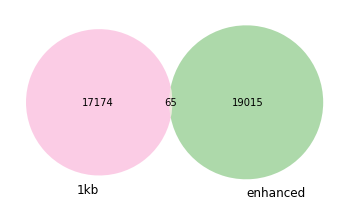

In [4]:
show_venn(enhanced_sigs, hr_sigs)

# _enhanced_sigs = enhanced_sigs.copy()
# _hr_sigs = set()
# for _hr_sig in hr_sigs:
#     flag = False
#     for _enhanced_sig in _enhanced_sigs:
#         if abs(_hr_sig[0]-_enhanced_sig[0])<3 and abs(_hr_sig[1]-_enhanced_sig[1])<3:
#             _hr_sigs.add(_enhanced_sig)
#             flag = True
#     _hr_sigs.add(_hr_sig)
#     if flag:
#         _enhanced_sigs.add(_hr_sig)

# show_venn(_enhanced_sigs, _hr_sigs)

In [5]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result):
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=(51/255, 160/255, 44/255), label='mine')
    axes.plot(x, hr_result, color=(177/255, 89/255, 40/255), label='hr')

    plt.xlabel('distance')
    plt.ylabel('nums')
    plt.legend()
    plt.show()

def figure(chip_seq_path):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 13):
        if chr not in all_hr_sig.keys():
            continue
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

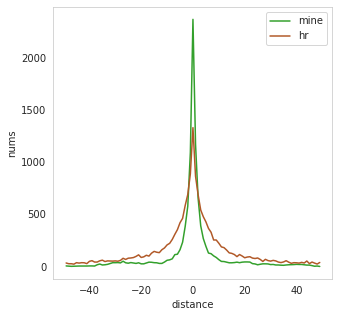

In [6]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path)

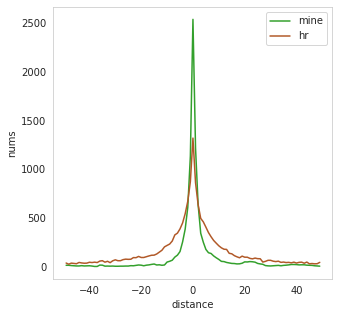

In [7]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path)

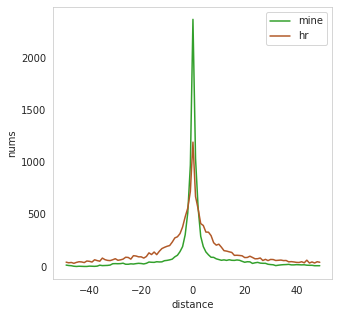

In [8]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path)

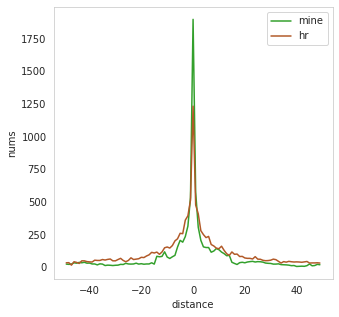

In [9]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path)

In [10]:
tss_file_path = os.path.join(auxiliary_files_path, 'Homo_sapiens.GRCh38.104.chr.gff3')

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_location = dict()
    gene_info = dict()
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if data[6] == '+':
                _location = data[3]
            elif data[6] == '-':
                _location = data[4]
            else:
                print('error')
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            if chromosome not in gene_location:
                gene_location[chromosome] = set()
            gene_location[chromosome].add(int(int(_location)/1000))
            
            _tmp = data[-1].split('Name=')
            if len(_tmp) < 2:
                continue
            gene_names = _tmp[1].split(';')[0]
            gene_ids = data[-1].split('ID=')[1].split(',')[0].split(';')[0]
            
            if chromosome not in gene_info:
                gene_info[chromosome] = set()
            gene_info[chromosome].add((int(int(_location)/1000), gene_names, gene_ids, data[-1].replace('\n', '')))
    return gene_location, gene_info

def figure_tss(locations):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 13):
        if chr not in locations:
            continue
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], locations[chr])
        hr_result = get_hit_indicators(all_hr_sig[chr], locations[chr])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

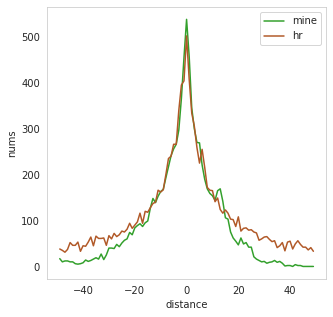

In [11]:
figure_tss(get_tss_gene_info('protein_coding')[0])

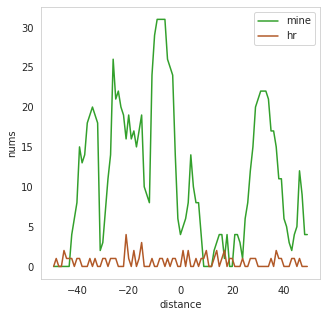

In [12]:
figure_tss(get_tss_gene_info('pseudogene')[0])

In [13]:
def get_hit_genes(significants, gene_info, genes_loop_nums):
    genes = set()
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for _info in gene_info:
            if abs(x-_info[0])<3 or abs(y-_info[0])<3:
                if _info[1] not in genes_loop_nums:
                    genes_loop_nums[_info[1]] = 1
                else:
                    genes_loop_nums[_info[1]] += 1
                genes.add((_info[1], _info[2], _info[3]))
    return genes, genes_loop_nums

def get_hit_gene_names(significants, gene_biotype='protein_coding'):
    gene_info = get_tss_gene_info(gene_biotype)[1]
    all_genes = set()
    genes_loop_nums = dict()
    for chr in range(1, 13):
        genes, genes_loop_nums = get_hit_genes(significants[chr], gene_info[chr], genes_loop_nums)
        all_genes = all_genes | genes
    return all_genes, genes_loop_nums

In [14]:
mine_hit_genes, mine_genes_loop_nums = get_hit_gene_names(all_enhanced_sig, gene_biotype='protein_coding')
mine_hit_genes = list(mine_hit_genes)
mine_hit_genes = np.array(mine_hit_genes)
print(len(mine_hit_genes))
print(mine_genes_loop_nums)

117
{'FCGR2B': 66, 'HSPA6': 19, 'CHD1L': 1, 'FMO5': 1, 'PRKAB2': 1, 'CDK11B': 15, 'CDK11A': 21, 'FCGR3B': 73, 'FCGR3A': 49, 'OR2T3': 24, 'H3C13': 27, 'FAM72D': 18, 'SRGAP2B': 18, 'OR2T5': 4, 'H2BC18': 21, 'RGS1': 4, 'OR2T34': 2, 'RABL2A': 43, 'CATIP': 17, 'PLEK': 15, 'ASTL': 28, 'BUB1': 49, 'PCBP1': 33, 'ANKRD36B': 10, 'ANKRD36': 6, 'IKZF2': 10, 'ACOXL': 2, 'C1GALT1C1L': 2, 'THADA': 2, 'UGT2B15': 5, 'ZDHHC11': 7, 'SUB1': 2, 'NHP2': 27, 'TPPP': 28, 'ZDHHC11B': 28, 'CHD1': 18, 'LMNB1': 26, 'HBEGF': 9, 'PFN3': 8, 'TRIM52': 1, 'NIPBL': 2, 'HLA-DPA1': 75, 'HLA-DOA': 77, 'SERPINB1': 42, 'H2BC17': 57, 'H3C12': 57, 'H2AC17': 57, 'HLA-C': 56, 'HLA-DRB1': 65, 'HLA-B': 34, 'H4C3': 12, 'H1-2': 4, 'HLA-DPB1': 49, 'H4C11': 12, 'HLA-DRB5': 31, 'H2BC14': 33, 'H2AC14': 33, 'ATP6V1G2': 7, 'NFKBIL1': 7, 'ATP6V1G2-DDX39B': 7, 'RIPK1': 2, 'HLA-DMA': 11, 'BRD2': 9, 'NT5DC1': 23, 'H3C10': 9, 'TAGAP': 4, 'PPARD': 10, 'HLA-E': 1, 'MPC1': 3, 'ULBP2': 4, 'EEF1A1': 1, 'UPK3BL1': 22, 'SPDYE2': 26, 'RASA4': 56, 'RA

In [15]:
hr_hit_genes, hr_genes_loop_nums = get_hit_gene_names(all_hr_sig, gene_biotype='protein_coding')
hr_hit_genes = list(hr_hit_genes)
hr_hit_genes = np.array(hr_hit_genes)
print(len(hr_hit_genes))
print(hr_genes_loop_nums)

1841
{'EFCAB2': 5, 'ADSS2': 1, 'RXFP4': 2, 'URB2': 2, 'TAF5L': 2, 'FHAD1': 2, 'AQP10': 1, 'ATP8B2': 1, 'NPL': 1, 'CHIT1': 2, 'ICMT': 2, 'TMCO2': 1, 'FGR': 2, 'APOBEC4': 1, 'RGL1': 1, 'ARPC5': 1, 'YTHDF2': 3, 'RAB3B': 5, 'KIAA2013': 1, 'HCRTR1': 3, 'SLC35F3': 2, 'SHISA4': 2, 'TIMM17A': 1, 'AHDC1': 3, 'GADD45A': 2, 'GPR25': 1, 'CELA2B': 1, 'WNT2B': 1, 'KIAA0040': 1, 'UBXN11': 2, 'PHLDA3': 2, 'AGMAT': 3, 'DDI2': 8, 'FAM76A': 1, 'ID3': 4, 'NIBAN1': 1, 'NID1': 1, 'SIKE1': 1, 'BEST4': 1, 'TPM3': 1, 'IL6R': 1, 'SH2D5': 1, 'KIF1B': 1, 'MAD2L2': 1, 'DRAXIN': 1, 'CENPS-CORT': 1, 'CENPS': 1, 'IVL': 2, 'TDRKH': 1, 'TEX50': 1, 'RNF19B': 1, 'RABIF': 1, 'ELOVL1': 1, 'ARHGEF2': 1, 'PSEN2': 1, 'SEMA6C': 6, 'TRIM62': 2, 'ZNF684': 1, 'PIK3C2B': 3, 'FCRL6': 1, 'PSMB2': 1, 'HMGCL': 1, 'CASP9': 3, 'DNAJC16': 3, 'ZBTB8OS': 2, 'RBBP4': 2, 'PDIK1L': 1, 'SMCP': 1, 'NRDC': 1, 'RSC1A1': 2, 'LMX1A': 1, 'CNR2': 1, 'LEMD1': 1, 'BLACAT1': 1, 'TRNAU1AP': 1, 'ATF3': 2, 'CCDC18': 1, 'NPR1': 1, 'SPEN': 4, 'ANGPTL3': 2, '